## 0. Install and Import Dependencies

In [1]:
!pip install mediapipe opencv-python pandas scikit-learn


[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import mediapipe as mp
import cv2 
import numpy as np

from sklearn.metrics import precision_score, accuracy_score, f1_score, recall_score, confusion_matrix, roc_curve, auc
import seaborn as sns
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression, SGDClassifier

In [3]:
mp_drawing = mp.solutions.drawing_utils # Drawing helpers
mp_pose = mp.solutions.pose

In [3]:
VIDEO_PATH = 'press.avi'
EXPORT_PATH = 'C:/Users/OS/Desktop/Kicking'
MODEL_PATH = 'hips.pkl'

## 1. Make Some Detections

In [27]:
import cv2
import mediapipe as mp

# Set the path to your local MP4 file
file_path = 'C:/Users/OS/Desktop/Kicking/kicking3.mp4'

# Initialize MediaPipe and VideoCapture
mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils

cap = cv2.VideoCapture(0)
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
fps = cap.get(cv2.CAP_PROP_FPS)
output_file = 'output.avi'

# Initialize VideoWriter
fourcc = cv2.VideoWriter_fourcc(*'XVID')  # You can change the codec as needed
videoWriter = cv2.VideoWriter(output_file, fourcc, fps, (width, height))

with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    while cap.isOpened():
        ret, image = cap.read()

        if not ret:
            break

        # Recolor Feed
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False

        # Make Detections
        results = pose.process(image)

        # Recolor image back to BGR for rendering
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                                  mp_drawing.DrawingSpec(color=(245, 117, 66), thickness=2, circle_radius=4),
                                  mp_drawing.DrawingSpec(color=(245, 66, 230), thickness=2, circle_radius=2))

        cv2.imshow('Raw Webcam Feed', image)
        videoWriter.write(image)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

cap.release()
videoWriter.release()
cv2.destroyAllWindows()


### 1.x Save Video

In [4]:
cap = cv2.VideoCapture(0)

height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)
width = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
fps = cap.get(cv2.CAP_PROP_FPS)
videoWriter = cv2.VideoWriter('press.avi', cv2. VideoWriter_fourcc('P', 'I','M', '1'), fps, (int(width), int(height)))

while cap.isOpened():
    ret, frame = cap.read()

    try:
        cv2.imshow('Press', frame)
        videoWriter.write(frame)
    except Exception as e:
        print(f"Error: {str(e)}")
        break

    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
videoWriter.release()
cv2.destroyAllWindows()

# 2. Capture Landmarks & Export to CSV

In [4]:
import csv
import os
import numpy as np
from matplotlib import pyplot as plt

In [5]:
landmarks = ['class']
for val in range(1, 33+1):
    landmarks += ['x{}'.format(val), 'y{}'.format(val), 'z{}'.format(val), 'v{}'.format(val)]

In [30]:
with open('choking.csv', mode='w', newline='') as f:
    csv_writer = csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    csv_writer.writerow(landmarks)

In [6]:
def export_landmark(results, action):
    try:
        keypoints = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten().tolist() 
        keypoints.insert(0, action)

        with open('choking.csv', mode='a', newline='') as f:
            csv_writer = csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
            csv_writer.writerow(keypoints)
    except Exception as e:
        pass


In [7]:
results.pose_landmarks

NameError: name 'results' is not defined

In [32]:
cap = cv2.VideoCapture('output.avi')
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))

# Define the maximum window size (adjust these values as needed)
max_window_width = 1280
max_window_height = 720

# Calculate the scaling factor to fit the video within the window
scale_factor = min(max_window_width / frame_width, max_window_height / frame_height)

# Calculate the new frame dimensions
new_width = int(frame_width * scale_factor)
new_height = int(frame_height * scale_factor)

# Initialize the Pose model
with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    while cap.isOpened():
        ret, frame = cap.read()

        # Check if the video frame was read successfully
        if not ret:
            break

        # Resize the video frame to fit within the window
        frame = cv2.resize(frame, (new_width, new_height))

        # Recolor Feed
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False

        # Make Detections
        results = pose.process(image)

        # Recolor image back to RGB for rendering
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        k = cv2.waitKey(1)
        if k == ord('c'):
            export_landmark(results, 'choking')
        if k == ord('n'):
            export_landmark(results, 'normal')

        cv2.imshow('Raw Webcam Feed', image)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

cap.release()
cv2.destroyAllWindows()

In [11]:
cap.release()
cv2.destroyAllWindows()

# 3. Train Custom Model Using Scikit Learn

## 3.1 Read in Collected Data and Process

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [8]:
df = pd.read_csv('choking.csv')

In [9]:
df.head()

,class,x1,y1,z1,v1,x2,y2,z2,v2,x3,...,z31,v31,x32,y32,z32,v32,x33,y33,z33,v33
0,normal,0.435128,0.114682,-0.435567,0.999964,0.444267,0.095209,-0.415878,0.999858,0.449967,...,0.202149,0.896457,0.472946,0.938432,0.217569,0.979036,0.399859,0.977793,0.033684,0.981172
1,normal,0.409591,0.136414,-0.438098,0.999943,0.415795,0.119014,-0.418129,0.999778,0.421410,...,0.297835,0.907567,0.477994,0.936711,0.088059,0.981495,0.350860,0.919132,0.147421,0.983102
2,normal,0.407662,0.136872,-0.444108,0.999936,0.414868,0.119567,-0.424023,0.999753,0.420506,...,0.295083,0.907198,0.478822,0.936746,0.073732,0.981622,0.351230,0.920904,0.143121,0.983105
3,normal,0.400955,0.137726,-0.447357,0.999935,0.408491,0.120197,-0.427286,0.999752,0.414501,...,0.300636,0.908308,0.480582,0.934993,0.073109,0.982095,0.351080,0.922072,0.149399,0.983326
4,normal,0.388901,0.137890,-0.408126,0.999935,0.396199,0.120233,-0.391140,0.999754,0.402082,...,0.310126,0.910771,0.481822,0.923598,0.083742,0.982680,0.351363,0.922140,0.165347,0.983798


In [10]:
df.tail()

,class,x1,y1,z1,v1,x2,y2,z2,v2,x3,...,z31,v31,x32,y32,z32,v32,x33,y33,z33,v33
3238,choking,0.365168,0.085165,-0.522561,0.999762,0.369221,0.065712,-0.490894,0.999522,0.373183,...,0.422838,0.475973,0.441424,1.090506,0.210833,0.620993,0.226256,1.033389,0.202481,0.687849
3239,choking,0.336826,0.064891,-0.473883,0.999776,0.341882,0.049703,-0.444302,0.999541,0.347142,...,0.380721,0.498457,0.441200,1.080478,0.112796,0.646782,0.221552,1.023320,0.164878,0.708811
3240,normal,0.394551,0.071420,-0.473134,0.999896,0.403730,0.057731,-0.449783,0.999627,0.409954,...,0.259411,0.681196,0.404047,1.006882,0.085072,0.801453,0.358318,1.003585,0.082406,0.822047
3241,normal,0.382476,0.074131,-0.384315,0.999826,0.388485,0.058172,-0.357365,0.999408,0.395186,...,0.347650,0.712190,0.412289,1.002554,0.173601,0.827069,0.375530,0.998625,0.160513,0.849125
3242,normal,0.379114,0.075725,-0.280172,0.999831,0.385078,0.058310,-0.252500,0.999451,0.391919,...,0.311459,0.742997,0.453776,1.012246,0.144442,0.850546,0.376427,1.017273,0.141957,0.872272


In [11]:
df[df['class']=='choking']

,class,x1,y1,z1,v1,x2,y2,z2,v2,x3,...,z31,v31,x32,y32,z32,v32,x33,y33,z33,v33
1692,choking,0.446091,0.141352,-0.313122,0.999933,0.454074,0.128801,-0.297896,0.999831,0.459607,...,0.273545,0.920964,0.501480,0.911912,-0.032539,0.990285,0.388413,0.911938,0.128812,0.988974
1693,choking,0.419800,0.161103,-0.160439,0.999321,0.429163,0.142462,-0.167782,0.998855,0.434033,...,0.315407,0.919757,0.502017,0.911114,0.097283,0.983829,0.386191,0.911831,0.194066,0.985909
1694,choking,0.418819,0.162438,-0.177525,0.999308,0.428277,0.143363,-0.184790,0.998845,0.433010,...,0.322706,0.922039,0.501603,0.911182,0.086542,0.983632,0.385526,0.911883,0.205751,0.985956
1695,choking,0.418851,0.162678,-0.168652,0.999229,0.428391,0.143479,-0.177443,0.998739,0.433229,...,0.345100,0.923960,0.501126,0.910646,0.064448,0.983372,0.384803,0.911855,0.228970,0.985824
1696,choking,0.418793,0.163934,-0.192862,0.999193,0.428440,0.144750,-0.196623,0.998672,0.433349,...,0.359628,0.925952,0.500185,0.910790,0.078607,0.983363,0.384546,0.910861,0.241259,0.986022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3235,choking,0.393136,0.106394,-0.492567,0.999689,0.399050,0.086833,-0.459539,0.999381,0.404011,...,0.272340,0.427512,0.434487,1.020095,0.271262,0.550669,0.245700,1.074852,0.067340,0.628931
3236,choking,0.385752,0.094368,-0.430555,0.999718,0.388521,0.076330,-0.402406,0.999437,0.392373,...,0.275566,0.448587,0.441702,1.036892,0.247395,0.572676,0.244123,1.068164,0.080477,0.648629
3237,choking,0.378566,0.098259,-0.452882,0.999744,0.380722,0.077203,-0.424748,0.999488,0.383955,...,0.342164,0.463153,0.441269,1.068965,0.219587,0.595333,0.227915,1.036138,0.141010,0.667918
3238,choking,0.365168,0.085165,-0.522561,0.999762,0.369221,0.065712,-0.490894,0.999522,0.373183,...,0.422838,0.475973,0.441424,1.090506,0.210833,0.620993,0.226256,1.033389,0.202481,0.687849


In [9]:
X = df.drop('class', axis=1)
y = df['class']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1500)

In [14]:
y_test

2364    choking
3046    choking
203      normal
55       normal
3195    choking
         ...   
2263    choking
189      normal
1425     normal
1167     normal
994      normal
Name: class, Length: 973, dtype: object

## 3.2 Train Machine Learning Classification Model

In [11]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.svm import SVC

In [12]:
pipelines = {
    'lr':make_pipeline(StandardScaler(), LogisticRegression()),
    'rc':make_pipeline(StandardScaler(), RidgeClassifier()),
    'rf':make_pipeline(StandardScaler(), RandomForestClassifier()),
    'gb':make_pipeline(StandardScaler(), GradientBoostingClassifier()),
    'svm':make_pipeline(StandardScaler(), SVC()),
}

In [13]:
fit_models = {}
for algo, pipeline in pipelines.items():
    model = pipeline.fit(X_train, y_train)
    fit_models[algo] = model

In [14]:
fit_models

{'lr': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('logisticregression', LogisticRegression())]),
 'rc': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('ridgeclassifier', RidgeClassifier())]),
 'rf': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('randomforestclassifier', RandomForestClassifier())]),
 'gb': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('gradientboostingclassifier', GradientBoostingClassifier())]),
 'svm': Pipeline(steps=[('standardscaler', StandardScaler()), ('svc', SVC())])}

In [15]:
fit_models['rc'].predict(X_test)

array(['choking', 'choking', 'normal', 'normal', 'choking', 'normal',
       'choking', 'choking', 'normal', 'normal', 'normal', 'normal',
       'normal', 'choking', 'normal', 'normal', 'choking', 'normal',
       'normal', 'normal', 'choking', 'normal', 'normal', 'normal',
       'choking', 'choking', 'choking', 'normal', 'choking', 'choking',
       'normal', 'choking', 'choking', 'choking', 'choking', 'normal',
       'choking', 'normal', 'normal', 'normal', 'normal', 'choking',
       'choking', 'normal', 'choking', 'normal', 'normal', 'choking',
       'choking', 'choking', 'choking', 'normal', 'choking', 'choking',
       'normal', 'choking', 'choking', 'normal', 'normal', 'choking',
       'choking', 'normal', 'choking', 'choking', 'normal', 'normal',
       'choking', 'normal', 'normal', 'choking', 'choking', 'normal',
       'normal', 'normal', 'choking', 'normal', 'choking', 'normal',
       'normal', 'normal', 'choking', 'normal', 'choking', 'normal',
       'choking', 'nor

## 3.3 Evaluate and Serial Model

In [16]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
import pickle

In [17]:
for algo, model in fit_models.items():
    yhat = model.predict(X_test)
    print(algo, accuracy_score(y_test.values, yhat), 
          precision_score(y_test.values, yhat, average="binary", pos_label="choking"),
          recall_score(y_test.values, yhat, average="binary", pos_label="choking"))

lr 0.9969167523124358 1.0 0.9934354485776805
rc 0.9958890030832477 1.0 0.9912472647702407
rf 0.9948612538540597 0.9934497816593887 0.9956236323851203
gb 0.9958890030832477 0.9956236323851203 0.9956236323851203
svm 0.9958890030832477 0.9978021978021978 0.9934354485776805


In [18]:
yhat = fit_models['rf'].predict(X_test)

In [19]:
yhat[:10]

array(['choking', 'choking', 'normal', 'normal', 'choking', 'normal',
       'choking', 'choking', 'normal', 'normal'], dtype=object)

In [20]:
with open('deadlift.pkl', 'wb') as f:
    pickle.dump(fit_models['rf'], f)

# 4. Make Detections with Model

In [21]:
with open('deadlift.pkl', 'rb') as f:
    model = pickle.load(f)

In [26]:
X = pd.DataFrame([row], columns=landmarks[1:])

NameError: name 'row' is not defined

In [23]:
cap = cv2.VideoCapture("C:/Users/OS/Pictures/Camera Roll/1.mp4")
# "C:/Users/OS/Pictures/Camera Roll/18-11-2023.mp4"
counter = 0
current_stage = ''
# Initiate holistic model
with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    while cap.isOpened():
        ret, frame = cap.read()

        # Recolor Feed
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False

        # Make Detections
        results = pose.process(image)

        # Recolor image back to BGR for rendering
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                                mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4),
                                mp_drawing.DrawingSpec(color=(245,117,230), thickness=2, circle_radius=2)
                                )

        try:
            row = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten().tolist()
            X = pd.DataFrame([row], columns=landmarks[1:])
            body_language_class = model.predict(X)[0]
            body_language_prob = model.predict_proba(X)[0]
            print(body_language_class, body_language_prob)
        
    
            if body_language_class == 'kicking' and body_language_prob[body_language_prob.argmax()] >= .7:
                current_stage = 'kicking'

            ## not sure
            elif current_stage == 'kicking' and body_language_class == 'normal' and body_language_prob[body_language_prob.argmax()] < .7:
                current_stage="normal"
                counter += 1
                print(current_stage)

            # Get status box
            cv2.rectangle(image, (0,0), (300, 60), (245, 117, 16), -1)
    
            # Display Class
            cv2.putText(image, 'CLASS'
                        , (130, 12), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)
            cv2.putText(image, body_language_class.split(' ')[0]
                        , (125, 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
            
            # Display Probability
            cv2.putText(image, 'PROB'
                        , (15, 12), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)
            cv2.putText(image, str(round(body_language_prob[np.argmax(body_language_prob)],2))
                        , (10, 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
            # Display Probability
            cv2.putText(image, 'COUNT'
                        , (250, 12), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)
            cv2.putText(image, str(counter)
                        , (245, 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
            
        
        except Exception as e:
            pass
    
        cv2.imshow('Raw Webcam Feed', image)
        
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
cap.release()
cv2.destroyAllWindows()

normal [0.25 0.75]
normal [0.23 0.77]
normal [0.24 0.76]
normal [0.28 0.72]
normal [0.29 0.71]
normal [0.19 0.81]
normal [0.22 0.78]
normal [0.25 0.75]
normal [0.22 0.78]
normal [0.16 0.84]
normal [0.12 0.88]
normal [0.11 0.89]
normal [0.07 0.93]
normal [0.07 0.93]
normal [0.04 0.96]
normal [0.08 0.92]
normal [0.1 0.9]
normal [0.13 0.87]
normal [0.1 0.9]
normal [0.1 0.9]
normal [0.05 0.95]
normal [0.06 0.94]
normal [0.05 0.95]
normal [0.1 0.9]
normal [0.09 0.91]
normal [0.07 0.93]
normal [0.08 0.92]
normal [0.11 0.89]
normal [0.09 0.91]
normal [0.12 0.88]
normal [0.17 0.83]
normal [0.2 0.8]
normal [0.19 0.81]
normal [0.21 0.79]
normal [0.21 0.79]
normal [0.19 0.81]
normal [0.21 0.79]
normal [0.22 0.78]
normal [0.23 0.77]
normal [0.26 0.74]
normal [0.25 0.75]
normal [0.23 0.77]
normal [0.24 0.76]
normal [0.25 0.75]
normal [0.23 0.77]
normal [0.22 0.78]
normal [0.21 0.79]
normal [0.21 0.79]
normal [0.21 0.79]
normal [0.21 0.79]
normal [0.2 0.8]
normal [0.21 0.79]
normal [0.2 0.8]
normal 

error: OpenCV(4.8.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


In [27]:
X_train

,x1,y1,z1,v1,x2,y2,z2,v2,x3,y3,...,z31,v31,x32,y32,z32,v32,x33,y33,z33,v33
714,0.467136,0.142144,-0.671694,0.999998,0.471101,0.127963,-0.610211,0.999990,0.476748,0.128754,...,0.566786,0.695832,0.420463,0.707884,0.348741,0.879103,0.357255,0.720300,0.328085,0.842957
475,0.667837,0.169028,-0.300352,0.999789,0.681124,0.155365,-0.275095,0.999353,0.690153,0.154329,...,0.606734,0.724346,0.792467,0.667940,0.076583,0.898110,0.651779,0.648494,0.429327,0.911406
366,0.576876,0.182227,-0.465660,0.999965,0.589916,0.169719,-0.439280,0.999911,0.599329,0.169119,...,0.670200,0.676821,0.698982,0.653606,0.104304,0.901752,0.557313,0.639736,0.468806,0.884317
746,0.481530,0.140057,-0.513151,0.999994,0.486077,0.126545,-0.469518,0.999972,0.492670,0.127489,...,0.396585,0.630713,0.457826,0.706891,0.286721,0.811731,0.370132,0.721978,0.225588,0.805373
330,0.560235,0.181366,-0.412827,0.999973,0.572795,0.168688,-0.382734,0.999922,0.581967,0.167664,...,0.508884,0.724202,0.702086,0.650721,0.092885,0.899326,0.571424,0.651273,0.318394,0.900388
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204,0.576116,0.180991,-0.661196,0.999920,0.588281,0.167371,-0.646786,0.999799,0.597358,0.166186,...,0.683739,0.787379,0.698253,0.655145,0.192105,0.925259,0.560326,0.652970,0.465681,0.923787
53,0.572813,0.156883,-0.579567,0.999967,0.586977,0.143330,-0.559711,0.999905,0.596410,0.142996,...,0.696414,0.760142,0.665816,0.631066,0.224033,0.930895,0.530099,0.624521,0.500386,0.921860
294,0.582124,0.178572,-0.433725,0.999950,0.595545,0.166313,-0.400334,0.999843,0.605417,0.165828,...,0.619783,0.735587,0.704910,0.654693,0.069138,0.922679,0.548029,0.644951,0.400625,0.910573
723,0.468719,0.142507,-0.618523,0.999998,0.474544,0.128079,-0.558823,0.999987,0.480267,0.128987,...,0.432348,0.658979,0.421856,0.707751,0.411994,0.874224,0.360218,0.721543,0.202635,0.830655


In [52]:
def describe_dataset(dataset_path: str):
    data = pd.read_csv(dataset_path)
    return data

def round_up_metric_results(results) -> list:
    '''Round up metrics results such as precision score, recall score, ...'''
    return list(map(lambda el: round(el, 3), results))

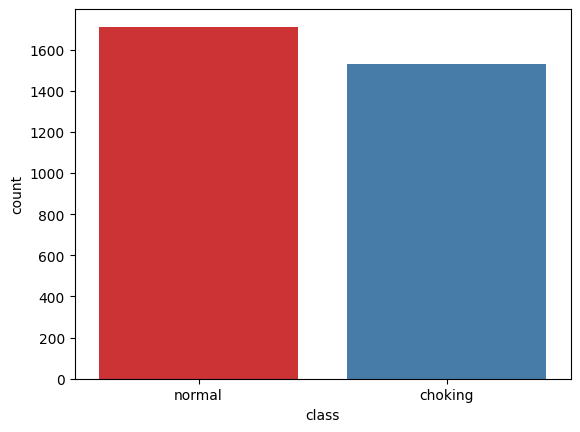

In [55]:
df = describe_dataset("./choking.csv")
sns.countplot(x='class', data=df, palette="Set1") 
df.loc[df["class"] == "choking", "class"] = 0
df.loc[df["class"] == "normal", "class"] = 1

In [56]:
X = df.drop("class", axis=1)
y = df["class"].astype('int')

sc = StandardScaler()
X = pd.DataFrame(sc.fit_transform(X))

In [57]:
# Split train set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)
y_test.head(3)

316     1
730     1
2184    0
Name: class, dtype: int32

In [58]:
algorithms =[("LR", LogisticRegression()),
         ("SVC", SVC(probability=True)),
         ('KNN',KNeighborsClassifier()),
         ("DTC", DecisionTreeClassifier()),
         ("SGDC", CalibratedClassifierCV(SGDClassifier())),
         ("NB", GaussianNB()),
         ('RF', RandomForestClassifier()),]

models = {}
final_results = []

for name, model in algorithms:
    trained_model = model.fit(X_train, y_train)
    models[name] = trained_model

    # Evaluate model
    model_results = model.predict(X_test)

    p_score = precision_score(y_test, model_results, average=None, labels=[0, 1])
    a_score = accuracy_score(y_test, model_results)
    r_score = recall_score(y_test, model_results, average=None, labels=[0, 1])
    f1_score_result = f1_score(y_test, model_results, average=None, labels=[0, 1])
    cm = confusion_matrix(y_test, model_results, labels=[0, 1])
    final_results.append(( name,  round_up_metric_results(p_score), a_score, round_up_metric_results(r_score), round_up_metric_results(f1_score_result), cm))

# Sort results by F1 score
final_results.sort(key=lambda k: sum(k[4]), reverse=True)
pd.DataFrame(final_results, columns=["Model", "Precision Score", "Accuracy score", "Recall Score", "F1 score", "Confusion Matrix"])


,Model,Precision Score,Accuracy score,Recall Score,F1 score,Confusion Matrix
0,KNN,"[1.0, 0.997]",0.998459,"[0.997, 1.0]","[0.998, 0.999]","[[304, 1], [0, 344]]"
1,RF,"[1.0, 0.997]",0.998459,"[0.997, 1.0]","[0.998, 0.999]","[[304, 1], [0, 344]]"
2,LR,"[1.0, 0.989]",0.993837,"[0.987, 1.0]","[0.993, 0.994]","[[301, 4], [0, 344]]"
3,SVC,"[1.0, 0.989]",0.993837,"[0.987, 1.0]","[0.993, 0.994]","[[301, 4], [0, 344]]"
4,DTC,"[0.997, 0.991]",0.993837,"[0.99, 0.997]","[0.993, 0.994]","[[302, 3], [1, 343]]"
5,SGDC,"[1.0, 0.989]",0.993837,"[0.987, 1.0]","[0.993, 0.994]","[[301, 4], [0, 344]]"
6,NB,"[0.935, 0.947]",0.941448,"[0.941, 0.942]","[0.938, 0.945]","[[287, 18], [20, 324]]"


In [59]:
test_df = describe_dataset("./choking.csv")
test_df.loc[test_df["class"] == "choking", "class"] = 0
test_df.loc[test_df["class"] == "normal", "class"] = 1

test_x = test_df.drop("class", axis=1)
test_y = test_df["class"].astype("int")

In [60]:
testset_final_results = []

for name, model in models.items():

    model_results = model.predict(test_x)

    p_score = precision_score(test_y, model_results, average="weighted")
    a_score = accuracy_score(test_y, model_results)
    r_score = recall_score(test_y, model_results, average="weighted")
    f1_score_result = f1_score(test_y, model_results, average="weighted")
    cm = confusion_matrix(test_y, model_results, labels=[0, 1])
    testset_final_results.append(( name,  (p_score), a_score, (r_score), (f1_score_result), cm ))


testset_final_results.sort(key=lambda k: k[4], reverse=True)
eval_df = pd.DataFrame(testset_final_results, columns=["Model", "Precision score", "Accuracy score", "Recall score", "F1 score", "Confusion Matrix"])
eval_df = eval_df.sort_values(by=['F1 score'], ascending=False).reset_index(drop=True)
eval_df.to_csv(f"evaluation.csv", sep=',', encoding='utf-8', index=False)
eval_df

C:\Users\OS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\OS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\OS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
C:\Users\OS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\OS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but SGDClassifier was fitted without feature names
  warnings.warn(
C:\Users\OS\AppData\Loca

,Model,Precision score,Accuracy score,Recall score,F1 score,Confusion Matrix
0,LR,0.961115,0.960530,0.960530,0.960556,"[[1494, 37], [91, 1621]]"
1,SVC,0.869882,0.827320,0.827320,0.820132,"[[971, 560], [0, 1712]]"
2,NB,0.836305,0.790626,0.790626,0.785928,"[[1482, 49], [630, 1082]]"
3,SGDC,0.778562,0.618563,0.618563,0.539908,"[[294, 1237], [0, 1712]]"
4,DTC,0.766291,0.580635,0.580635,0.472695,"[[171, 1360], [0, 1712]]"
5,KNN,0.751123,0.529140,0.529140,0.367548,"[[4, 1527], [0, 1712]]"
6,RF,0.278685,0.527906,0.527906,0.364793,"[[0, 1531], [0, 1712]]"


In [64]:
# with open("./deadlift.pkl", "wb") as f:
#     pickle.dump(models, f)
with open("./deadlift.pkl", "wb") as f:
    pickle.dump(models["LR"], f)
# with open("./model/SGDC_model.pkl", "wb") as f:
#     pickle.dump(models["SGDC"], f)

In [65]:
best_model = models["LR"]
y_predictions = best_model.predict(test_x)

p_score = precision_score(test_y, y_predictions, labels=[0, 1], average=None)
r_score = recall_score(test_y, y_predictions, labels=[0, 1], average=None)
f1_score_result = f1_score(test_y, y_predictions, labels=[0, 1], average=None)

p_score, r_score, f1_score_result

C:\Users\OS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


(array([0.94258675, 0.97768396]),
 array([0.97583279, 0.94684579]),
 array([0.95892169, 0.9620178 ]))

<Axes: >

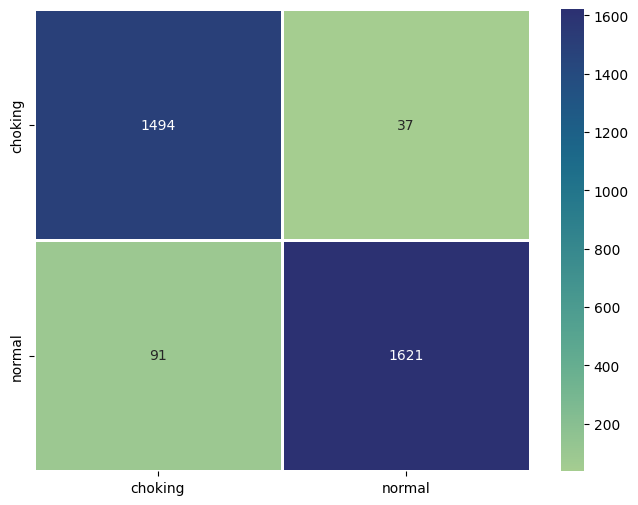

In [67]:
KNN_cm = eval_df[ eval_df["Model"] == 'LR' ]["Confusion Matrix"].values[0]

cm_array_df = pd.DataFrame(KNN_cm, index=["choking", "normal"], columns=["choking", "normal"])

fig, ax = plt.subplots(figsize=(8,6)) 
sns.heatmap(cm_array_df, linewidths=1, annot=True, ax=ax, fmt='g', cmap="crest")

In [68]:
def to_labels(y_pred, y_pred_proba, threshold):
    results = []

    for index, predicted_class in enumerate(y_pred):
        prediction_probabilities = y_pred_proba[index]
        class_prediction_probability = round(prediction_probabilities[np.argmax(prediction_probabilities)], 2)

        results.append(predicted_class if class_prediction_probability >= threshold else -1)
    
    return results


def calculate_correlation_score_confidence(test_x, test_y):
    y_predictions = best_model.predict(test_x)
    y_predict_proba = best_model.predict_proba(test_x)

    thresholds = list(np.arange(0, 1.05, 0.01))

    f1_score_results = []

    for threshold in thresholds:
        true_predictions = to_labels(y_predictions, y_predict_proba, threshold)
        f1_s = list(f1_score(test_y, true_predictions, labels=[0, 1], average=None))
        all_class_f1 = f1_score(test_y, true_predictions, labels=[0, 1], average="weighted")
        f1_s.append(all_class_f1)
        f1_score_results.append(f1_s)
    
    return thresholds, f1_score_results

C:\Users\OS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\OS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


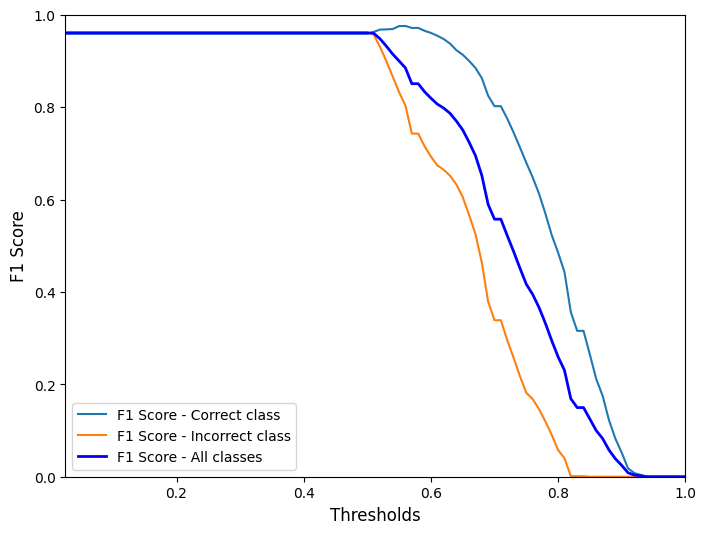

In [69]:
thresholds, f1_scores = calculate_correlation_score_confidence(test_x, test_y)

first_class = [ el[0] for el in f1_scores ]
second_class = [ el[1] for el in f1_scores ]
all_classes = [ el[2] for el in f1_scores ]

fig, ax = plt.subplots(figsize=(8,6))
plt.plot(thresholds, first_class, label = "F1 Score - Correct class")
plt.plot(thresholds, second_class, label = "F1 Score - Incorrect class")
plt.plot(thresholds, all_classes, label = "F1 Score - All classes", linewidth=2.0, color="blue")
plt.legend(loc = 'lower left')
plt.ylim([0, 1])
plt.xlim([0.025, 1])
plt.xlabel("Thresholds", fontsize = 12)
plt.ylabel("F1 Score", fontsize = 12)
# plt.axvline(thresholds[np.argmin(abs(precision-recall))], color="k", ls = "--")
# plt.title(label = F"Threshold = {thresholds[np.argmin(abs(precision-recall))]:.3f}", fontsize = 12)
plt.show()

C:\Users\OS\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


Optimal Threshold: 0.4477110009934866


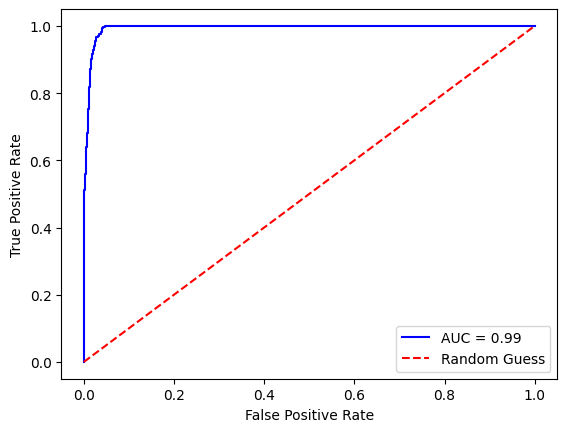

In [70]:
probs = best_model.predict_proba(test_x)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(test_y, preds)
roc_auc = auc(fpr, tpr)

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = threshold[optimal_idx]
print(f"Optimal Threshold: {optimal_threshold}")

# method I: plt
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1],'r--', label="Random Guess")
plt.legend(loc=4)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()